In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import log_loss

In [2]:
data = pd.read_csv('../data/data.csv')
unused = 'oaid_hash, banner_id0, banner_id1, rate0, rate1, g0, g1, coeff_sum0, coeff_sum1'.split(', ')
data = data.drop(columns=unused)
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,0,0,0,1,1
1,2021-09-26 22:54:49.000000,1,1,0,0,1,1,1
2,2021-09-26 23:57:20.000000,2,2,3,0,0,1,1
3,2021-09-27 00:04:30.000000,3,3,0,1,1,1,1
4,2021-09-27 00:06:21.000000,4,4,0,1,0,1,1


Определим последний день и разобьем данные на тренировочные и тестовые

In [3]:
data['date_time'].max()

'2021-10-02 23:59:59.000000'

In [4]:
last_day = '2021-10-02'
data = data.sort_values(by='date_time')
splitting_mask = data['date_time'].str.startswith(last_day)

Посмотрим на количества значений в столбцах

In [5]:
for col in data.columns:
    print(data[col].value_counts())

2021-09-29 19:14:40.000000    140
2021-09-26 17:08:47.000000    134
2021-09-29 19:11:38.000000    131
2021-09-29 19:13:10.000000    130
2021-09-29 19:14:01.000000    129
                             ... 
2021-10-01 17:12:19.000000      1
2021-10-01 17:15:52.000000      1
2021-10-01 17:16:01.000000      1
2021-10-01 17:16:41.000000      1
2021-10-01 17:18:10.000000      1
Name: date_time, Length: 604712, dtype: int64
17      2280422
14      1638642
12       736352
0        708379
19       693292
         ...   
2843          1
2845          1
2847          1
2848          1
3442          1
Name: zone_id, Length: 3444, dtype: int64
22      613367
361     387563
3       286999
18      262946
21      246378
         ...  
1119         1
1120         1
1358         1
1355         1
1632         1
Name: banner_id, Length: 1633, dtype: int64
0      13682452
1       1236822
2        342937
3        173528
4        100293
         ...   
798           1
801           1
802           1
804      

`impressions` всегда равно 1, что логично, поэтому эту фичу не будем использовать

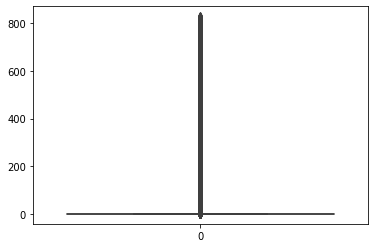

In [6]:
sns.boxplot(data=data['campaign_clicks']);

У `campaign_clicks` очень сильный скос, поэтому в дальнейшем все значения, большие 9, объединим в один класс

In [7]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # удаляем столбец impressions
    data = data.drop(columns=['impressions'])
    
    # выделяем из даты часы
    dates = pd.to_datetime(data['date_time'])
    data['hour'] = dates.dt.hour
    data = data.drop(columns=['date_time'])
    
    zone = data['zone_id'].value_counts()
    zone_rare = zone[zone == 1].index
    data[[v in zone_rare for v in data['banner_id']]] = -1

    banner = data['banner_id'].value_counts()
    banner_rare = banner[banner == 1].index
    data[[v in banner_rare for v in data['banner_id']]] = -1
    
    # интеракции
#     for banner in set(data['banner_id']):
#         for country in set(data['country_id']):
#             data[ f'{banner}x{country}'] = ((data['banner_id'] == banner) & (data['country_id'] == country)).astype(int)
    
    # one-hot
    data = data.join(pd.get_dummies(data['hour'], prefix='hour'))
    data = data.join(pd.get_dummies(data['os_id'], prefix='os_id'))
    data = data.join(pd.get_dummies(data['country_id'], prefix='country_id'))
#     data = data.join(pd.get_dummies(data['zone_id'], prefix='zone_id'))
#     data = data.join(pd.get_dummies(data['banner_id'], prefix='banner_id'))
    
    # все очень большие значение положим в один класс, так как их мало
    data['campaign_clicks'][data['campaign_clicks'] > 9] = 10
    data = data.join(pd.get_dummies(data['campaign_clicks'], prefix='campaign_clicks'))
    
    # удаление после one-hot
#     data = data.drop(columns=['hour', 'os_id', 'country_id', 'campaign_clicks', 'zone_id', 'banner_id'])
    data = data.drop(columns=['hour', 'os_id', 'country_id', 'campaign_clicks'])
    return data

In [8]:
def create_model(data: pd.DataFrame, C: float):
    X, y = data.drop(columns=['clicks']), data['clicks']
    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)
    return model


def evaluate_model(data: pd.DataFrame, model):
    X, y = data.drop(columns=['clicks']), data['clicks']
    return log_loss(y, model.predict_proba(X))

In [9]:
def cv(data: pd.DataFrame):
    split = TimeSeriesSplit(n_splits=4)
    best_loss, best_C = np.infty, None
    for C in [1.0, 10.0, 20.0]:
        scores = []
        for train_index, test_index in split.split(data):
            model = create_model(data.iloc[train_index], C)
            scores.append(evaluate_model(data.iloc[test_index], model))
        loss = np.mean(scores)
        if loss < best_loss:
            best_loss = loss
            best_C = C
    return create_model(data, C)

Запустим построение фич на всех данных

In [10]:
data_fe = feature_engineering(data)
data_train, data_test = data_fe[~splitting_mask], data_fe[splitting_mask]

<ipython-input-7-84a78e97562c>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['campaign_clicks'][data['campaign_clicks'] > 9] = 10


Подберем модель на TimeSeriesSplit кросс-валидации

In [11]:
model = cv(data_train)
evaluate_model(data_test, model)

0.14407991004952259